## Capstone- Cancer Histopathology: Exploratory Data Anaylsis (EDA)

Dataset:
- A. Borkowski, "Lung and Colon Cancer Histopathological Images", Kaggle.com, 2020. [Online]. Available: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images. [Accessed: 30- Jul- 2022].

Sources:
- Borkowski AA, Bui MM, Thomas LB, Wilson CP, DeLand LA, Mastorides SM. Lung and Colon Cancer Histopathological Image Dataset (LC25000). arXiv:1912.12142v1 [eess.IV], 2019

Image Labels:
- Lung benign tissue: 3
- Lung adenocarcinoma: 2
- Lung squamous cell carcinoma: 4
- Colon adenocarcinoma: 0
- Colon benign tissue: 1

### Import Libraries

In [6]:
## Import Libraries
import numpy as np
import pandas as pd
from pathlib import Path
import time
import math

# import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.utils import to_categorical
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Load Data

In [7]:
import PIL
from PIL import Image
import glob
import cv2
import os, os.path
from numpy import asarray

import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from IPython.display import display, HTML
import pymongo
from pymongo import MongoClient
import io
from bson.binary import Binary

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
%%time
dfShuffledData= pd.DataFrame(np.load('shufGenData96.npy', allow_pickle= True),
                             columns=['imageVector', 'label', 'classLabel', 'image', 'labelName'])
dfShuffledData.head()

CPU times: total: 3.17 s
Wall time: 23.7 s


,imageVector,label,classLabel,image,labelName
0,"[[[0.9960785, 0.98823535, 0.9921569], [0.98823...","[1.0, 0.0, 0.0, 0.0, 0.0]",0,<PIL.Image.Image image mode=RGB size=96x96 at ...,colon_aca
1,"[[[0.98823535, 0.97647065, 0.9568628], [0.8470...","[1.0, 0.0, 0.0, 0.0, 0.0]",0,<PIL.Image.Image image mode=RGB size=96x96 at ...,colon_aca
2,"[[[0.79215693, 0.6745098, 0.96470594], [0.7647...","[0.0, 0.0, 1.0, 0.0, 0.0]",2,<PIL.Image.Image image mode=RGB size=96x96 at ...,lung_aca
3,"[[[0.83921576, 0.5647059, 0.7686275], [0.85882...","[0.0, 0.0, 0.0, 1.0, 0.0]",3,<PIL.Image.Image image mode=RGB size=96x96 at ...,lung_n
4,"[[[0.40000004, 0.21176472, 0.7411765], [0.1647...","[0.0, 0.0, 0.0, 0.0, 1.0]",4,<PIL.Image.Image image mode=RGB size=96x96 at ...,lung_scc


In [10]:
dfShuffledData['classLabel'].value_counts()

0    5000
2    5000
3    5000
4    5000
1    5000
Name: classLabel, dtype: int64

In [11]:
%%time
imgVectData01= np.array(dfShuffledData['imageVector'].tolist())
imgVectData01.shape

CPU times: total: 1.08 s
Wall time: 1.93 s


(25000, 96, 96, 3)

In [12]:
labelData01= np.array(dfShuffledData['label'].tolist())
labelData01.shape

(25000, 5)

In [13]:
dfImageLabel= dfShuffledData.groupby('labelName')['image'].count()
# dfLabelNum= dfData.groupby('label')['text'].count()
dfImageLabel

labelName
colon_aca    5000
colon_n      5000
lung_aca     5000
lung_n       5000
lung_scc     5000
Name: image, dtype: int64

In [14]:
dfImageLabel.index.values

array(['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc'],
      dtype=object)

In [15]:
imageTag= ['image01', 'image02', 'image03']

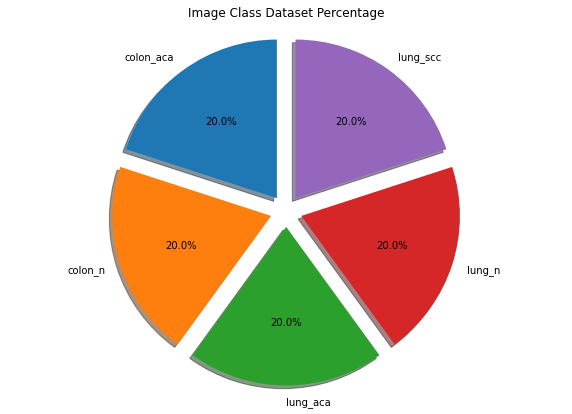

In [16]:
# plot frequency of some observations using pie chart
plt.rcParams['figure.figsize'] = (10, 7)

# fig = plt.figure(figsize =(10, 7))
x = np.arange(-10,11,1)
labels =  dfImageLabel.index
frequency = dfImageLabel
fig1, ax1 = plt.subplots()
explode = (0.1, 0.1, 0.1, 0.1, 0.1)  # only "explode" the 3rd slice (i.e. 'Data Scientist')
ax1.pie(frequency, explode= explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Image Class Dataset Percentage')
plt.savefig(f'{imageTag[0]}.png', facecolor='w', bbox_inches="tight",
            pad_inches=0.3, transparent=True)
plt.show()

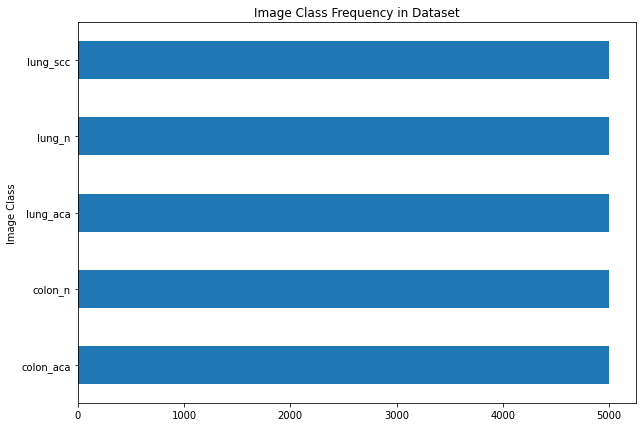

In [17]:
ax= dfImageLabel.plot.barh(x='text', y= dfImageLabel.index)
# ax.set_xlabel('Months')
ax.set_ylabel('Image Class')
ax.set_title('Image Class Frequency in Dataset')
plt.savefig(f'{imageTag[1]}.png', facecolor='w', bbox_inches="tight",
            pad_inches=0.3, transparent=True)

From initial analysis of the dataset, the graphs indicate that the data is balanced across the 5 classes

### Sample Images

In [18]:
dfShuffledData[0:5].values

array([[array([[[0.9960785 , 0.98823535, 0.9921569 ],
                [0.98823535, 1.        , 0.9450981 ],
                [0.9803922 , 0.9725491 , 0.92549026],
                ...,
                [0.6745098 , 0.59607846, 0.8352942 ],
                [0.9843138 , 0.95294124, 0.9960785 ],
                [0.9843138 , 0.8941177 , 0.9568628 ]],

               [[0.8196079 , 0.64705884, 0.8470589 ],
                [0.90196085, 0.8000001 , 0.91372555],
                [0.85098046, 0.7137255 , 0.87843144],
                ...,
                [0.6862745 , 0.58431375, 0.83921576],
                [0.9490197 , 0.82745105, 0.95294124],
                [0.97647065, 0.854902  , 0.97647065]],

               [[0.9333334 , 0.8196079 , 0.94117653],
                [1.        , 0.9568628 , 0.9568628 ],
                [0.9686275 , 0.8431373 , 1.        ],
                ...,
                [0.7254902 , 0.61960787, 0.882353  ],
                [0.8588236 , 0.75294125, 0.9294118 ],
               

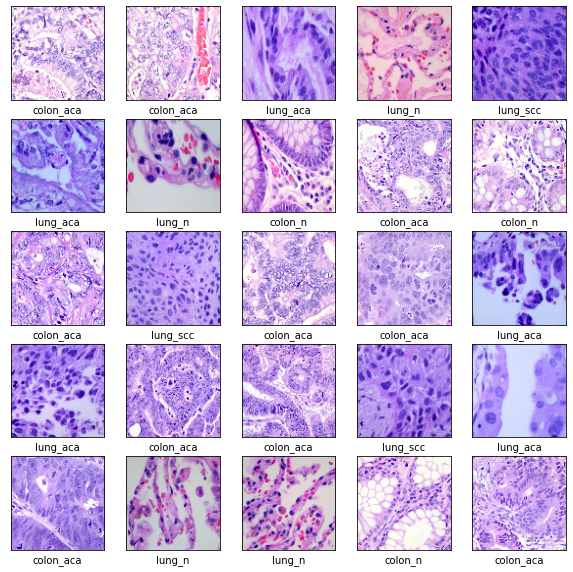

In [19]:
plt.figure(figsize=(10, 10))
for index, i in enumerate(dfShuffledData[0:25].values):
#     print(index)
    plt.subplot(5, 5, index+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(i[0])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(i[4])
    plt.savefig(f'{imageTag[2]}.png', facecolor= 'w', bbox_inches= "tight",
            pad_inches= 0.3, transparent= True)
plt.show()

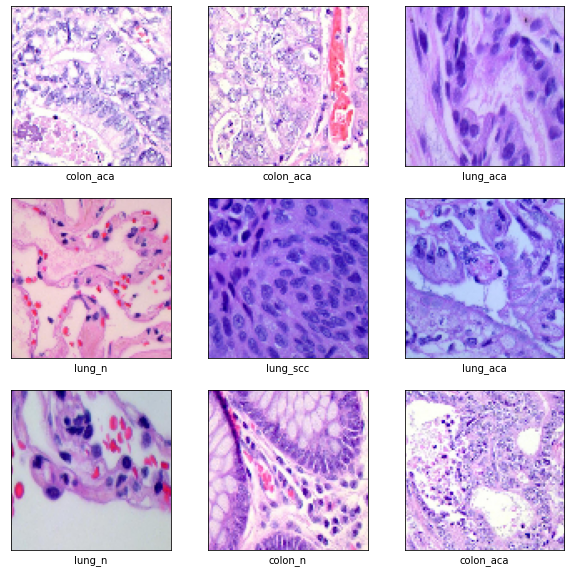

In [20]:
plt.figure(figsize=(10, 10))
for index, i in enumerate(dfShuffledData[0:9].values):
#     print(index)
    plt.subplot(3, 3, index+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(i[0])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(i[4])
    plt.savefig(f'image41.png', facecolor= 'w', bbox_inches= "tight",
            pad_inches= 0.3, transparent= True)
plt.show()

In [21]:
arr1d= dfShuffledData['imageVector'][0].reshape(-1)

In [22]:
def flattenArray(imageArray):
    flatArr= imageArray.reshape(-1)
    return flatArr

In [23]:
dfShuffledData['flattenImage']= dfShuffledData['imageVector'].apply(lambda x: flattenArray(x))

In [24]:
dfShuffledData.head()

,imageVector,label,classLabel,image,labelName,flattenImage
0,"[[[0.9960785, 0.98823535, 0.9921569], [0.98823...","[1.0, 0.0, 0.0, 0.0, 0.0]",0,<PIL.Image.Image image mode=RGB size=96x96 at ...,colon_aca,"[0.9960785, 0.98823535, 0.9921569, 0.98823535,..."
1,"[[[0.98823535, 0.97647065, 0.9568628], [0.8470...","[1.0, 0.0, 0.0, 0.0, 0.0]",0,<PIL.Image.Image image mode=RGB size=96x96 at ...,colon_aca,"[0.98823535, 0.97647065, 0.9568628, 0.8470589,..."
2,"[[[0.79215693, 0.6745098, 0.96470594], [0.7647...","[0.0, 0.0, 1.0, 0.0, 0.0]",2,<PIL.Image.Image image mode=RGB size=96x96 at ...,lung_aca,"[0.79215693, 0.6745098, 0.96470594, 0.76470596..."
3,"[[[0.83921576, 0.5647059, 0.7686275], [0.85882...","[0.0, 0.0, 0.0, 1.0, 0.0]",3,<PIL.Image.Image image mode=RGB size=96x96 at ...,lung_n,"[0.83921576, 0.5647059, 0.7686275, 0.8588236, ..."
4,"[[[0.40000004, 0.21176472, 0.7411765], [0.1647...","[0.0, 0.0, 0.0, 0.0, 1.0]",4,<PIL.Image.Image image mode=RGB size=96x96 at ...,lung_scc,"[0.40000004, 0.21176472, 0.7411765, 0.16470589..."


In [25]:
flatImgArr= np.array(dfShuffledData['flattenImage'].tolist())

In [26]:
dfFlatImg= pd.DataFrame(flatImgArr)

In [27]:
dfFlatImg.head()

,0,1,2,3,4,5,6,7,8,9,...,27638,27639,27640,27641,27642,27643,27644,27645,27646,27647
0,0.996078,0.988235,0.992157,0.988235,1.000000,0.945098,0.980392,0.972549,0.925490,0.815686,...,0.780392,0.972549,0.992157,0.968628,0.992157,0.909804,0.968628,0.913726,0.749020,0.898039
1,0.988235,0.976471,0.956863,0.847059,0.733333,0.850980,0.929412,0.921569,0.870588,0.980392,...,0.968628,0.960784,0.901961,0.921569,1.000000,0.823529,0.964706,0.901961,0.658824,0.913726
2,0.792157,0.674510,0.964706,0.764706,0.592157,0.972549,0.776471,0.584314,0.996078,0.733333,...,0.933333,0.776471,0.623529,0.949020,0.650980,0.486275,0.909804,0.705882,0.607843,0.933333
3,0.839216,0.564706,0.768628,0.858824,0.556863,0.768628,0.882353,0.556863,0.776471,0.811765,...,0.749020,0.882353,0.580392,0.752941,0.898039,0.588235,0.764706,0.890196,0.580392,0.756863
4,0.400000,0.211765,0.741176,0.164706,0.000000,0.650980,0.109804,0.000000,0.603922,0.137255,...,0.756863,0.333333,0.192157,0.725490,0.352941,0.211765,0.705882,0.454902,0.317647,0.780392


In [28]:
dfFlatImg['target']= dfShuffledData['classLabel']

In [29]:
dfFlatImg.head()

,0,1,2,3,4,5,6,7,8,9,...,27639,27640,27641,27642,27643,27644,27645,27646,27647,target
0,0.996078,0.988235,0.992157,0.988235,1.000000,0.945098,0.980392,0.972549,0.925490,0.815686,...,0.972549,0.992157,0.968628,0.992157,0.909804,0.968628,0.913726,0.749020,0.898039,0
1,0.988235,0.976471,0.956863,0.847059,0.733333,0.850980,0.929412,0.921569,0.870588,0.980392,...,0.960784,0.901961,0.921569,1.000000,0.823529,0.964706,0.901961,0.658824,0.913726,0
2,0.792157,0.674510,0.964706,0.764706,0.592157,0.972549,0.776471,0.584314,0.996078,0.733333,...,0.776471,0.623529,0.949020,0.650980,0.486275,0.909804,0.705882,0.607843,0.933333,2
3,0.839216,0.564706,0.768628,0.858824,0.556863,0.768628,0.882353,0.556863,0.776471,0.811765,...,0.882353,0.580392,0.752941,0.898039,0.588235,0.764706,0.890196,0.580392,0.756863,3
4,0.400000,0.211765,0.741176,0.164706,0.000000,0.650980,0.109804,0.000000,0.603922,0.137255,...,0.333333,0.192157,0.725490,0.352941,0.211765,0.705882,0.454902,0.317647,0.780392,4


In [30]:
dfFlatImg.shape

(25000, 27649)

In [31]:
dfFlatImg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Columns: 27649 entries, 0 to target
dtypes: float32(27648), object(1)
memory usage: 2.6+ GB
